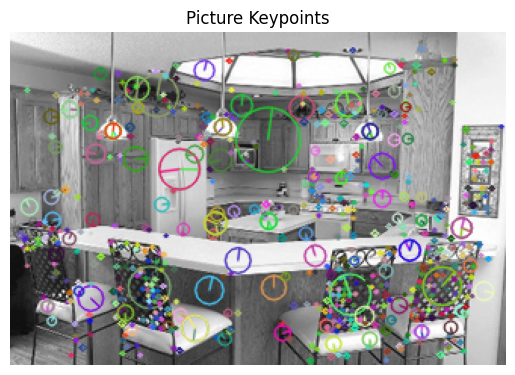

In [2]:
import cv2
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt


#  加载数据
def load_images_from_folder(folder, train_size):
    """
    从文件中读取图片并分为训练集和测试集

    Args:
        folder (string): 文件夹路径
        train_size (int): 训练集的大小

    Returns:
        list: 训练集和测试集的图像和标签
    """
    train_images, train_labels, test_images, test_labels = [], [], [], []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for i, image_filename in enumerate(os.listdir(path)):
                img = cv2.imread(
                    os.path.join(path, image_filename), cv2.IMREAD_GRAYSCALE
                )
                if img is not None:
                    if i < train_size:
                        train_images.append(img)
                        train_labels.append(label)
                    else:
                        test_images.append(img)
                        test_labels.append(label)
    return train_images, test_images, train_labels, test_labels


folder = "data/15-Scene"
test_folder = "data/test_img"  # 仅仅用测试
X_train, X_test, y_train, y_test = load_images_from_folder(folder, 150)


# sift提取特征
def extract_sift_features(X):
    """
    使用sift提取特征

    Args:
        X (list): 图像数据的列表

    Returns:
        list: sift得到的descriptors(128维)和keypoints
    """
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for img in X:
        kp, des = sift.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(des)
        # print(des.shape) # 看看维度，默认特征序列长度为128
    return descriptors, keypoints


def show_features_in_img(X, keypoints):
    """
    用于在图像上画出keypoints

    Args:
        X (list): 图像数据的列表
        keypoints (list): 关键点，包含位置和方向
    """
    # 绘制关键点
    img_with_keypoints = cv2.drawKeypoints(
        X, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # 使用matplotlib显示图
    plt.imshow(img_with_keypoints)
    plt.title("Picture Keypoints")
    plt.axis("off")
    plt.show()


def build_vocabulary(descriptors_list, k):
    """
    使用Kmean方法对特征进行聚类

    Args:
        descriptors_list (list): 图像的SIFT描述符列表，每个元素是一个图像的描述符。
        k (int): 聚类的数量

    Returns:
        KMeans: kmeans模型
    """
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


def features_to_histogram(features, vocab_model):
    """
    通过聚类模型计算一张图上不同种类特征的数量

    Args:
        features (list): 图像的SIFT描述符列表，每个元素是一个图像的描述符。
        vocab_model (KMeans): 训练好的KMeans聚类模型，用于将SIFT描述符映射到视觉词汇。

    Returns:
        array: 一个图像的特征直方图，显示每个视觉词汇的出现频率。
    """
    histogram = np.zeros(len(vocab_model.cluster_centers_))
    words = vocab_model.predict(features)
    for w in words:
        histogram[w] += 1
    return histogram


def prepare_histograms(descriptors_list, vocab_model):
    """
    为每个图像生成特征直方图。

    Args:
        descriptors_list (list): 图像的SIFT描述符列表，每个元素是一个图像的描述符。
        vocab_model (KMeans): 训练好的KMeans聚类模型，用于将SIFT描述符映射到视觉词汇。

    Returns:
        list: 包含每个图像的特征直方图的列表。每个直方图是根据图像的描述符与聚类中心的匹配程度生成的。
    """
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None:
            histogram = features_to_histogram(descriptors, vocab_model)
            histograms.append(histogram)
        else:
            histograms.append(None)
    return histograms


def plot_histogram(histogram):
    """
    绘制特征直方图。

    Args:
        histogram (array): 一个图像的特征直方图，显示每个视觉词汇的出现频率。

    Description:
        这个函数创建一个条形图，显示了在聚类过程中形成的每个视觉词汇在图像中的出现频率。
    """
    # 创建一个条形图
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(histogram)), histogram, color="blue")  # 为每个视觉词生成一个条形
    plt.title("Visual Word Occurrences")
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.show()


def plot_confusion_matrix(cm, class_labels, title="Confusion Matrix"):
    """
    可视化混淆矩阵。

    Args:
        cm (array-like): 混淆矩阵，通常由 sklearn.metrics.confusion_matrix 生成。
        class_labels (list of str): 类别标签列表，用于标记混淆矩阵的行和列。
        title (str, optional): 图表的标题。默认为 'Confusion Matrix'.
    """
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        cm,
        annot=True,
        fmt="g",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


train_descriptors, train_keypoints = extract_sift_features(X_train)
test_descriptors, test_keypoints = extract_sift_features(X_test)

show_features_in_img(X_train[0], train_keypoints[0])

def test(k, kernel):
    """
    方便测试

    Args:
        k (int): 聚类的数量
        kernel (string): svm的核
    """    
    vocab_model = build_vocabulary(train_descriptors, k)

    train_histograms = prepare_histograms(train_descriptors, vocab_model)
    test_histograms = prepare_histograms(test_descriptors, vocab_model)

    plot_histogram(train_histograms[0])

    # 处理可能的None值
    train_histograms = [
        hist if hist is not None else np.zeros(k) for hist in train_histograms
    ]
    test_histograms = [
        hist if hist is not None else np.zeros(k) for hist in test_histograms
    ]

    # SVM训练
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)


    clf = SVC(kernel=kernel)
    clf.fit(train_histograms, y_train_encoded)


    predictions = clf.predict(test_histograms)
    print(classification_report(y_test_encoded, predictions, target_names=le.classes_))

    cm = confusion_matrix(y_test_encoded, predictions)
    print("Confusion Matrix:")
    print(cm)

    # 可视化混淆矩阵
    plot_confusion_matrix(cm, le.classes_)

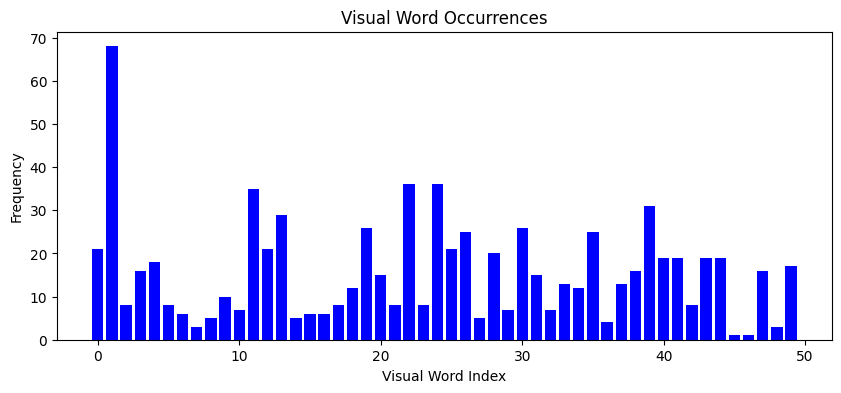

              precision    recall  f1-score   support

          00       0.20      0.45      0.28        66
          01       0.78      0.87      0.82        91
          02       0.27      0.35      0.31       161
          03       0.21      0.35      0.26        60
          04       0.39      0.26      0.31       139
          05       0.56      0.62      0.59       210
          06       0.73      0.83      0.78       178
          07       0.35      0.48      0.40       110
          08       0.52      0.49      0.50       158
          09       0.58      0.50      0.54       224
          10       0.60      0.41      0.48       260
          11       0.50      0.44      0.47       142
          12       0.57      0.37      0.45       206
          13       0.29      0.45      0.35        65
          14       0.58      0.44      0.50       165

    accuracy                           0.49      2235
   macro avg       0.48      0.49      0.47      2235
weighted avg       0.52   

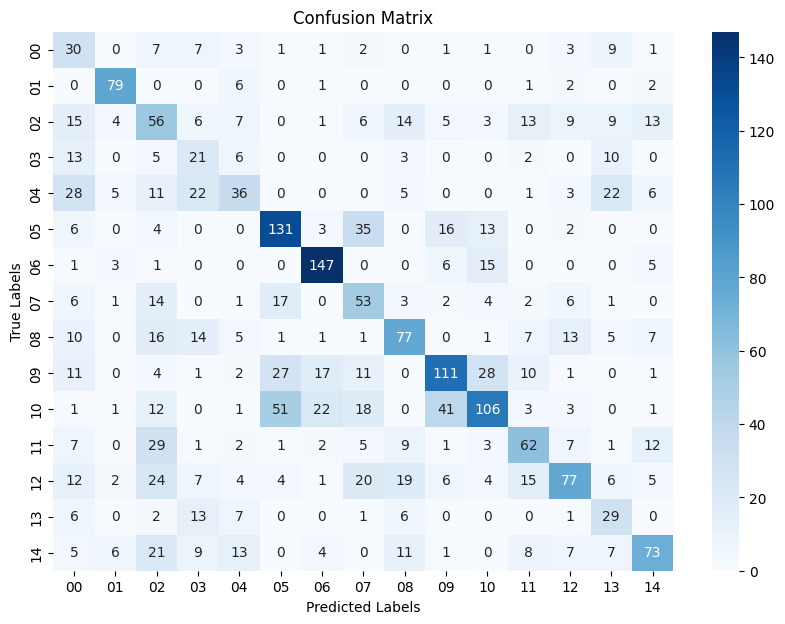

In [3]:
test(50, 'linear')

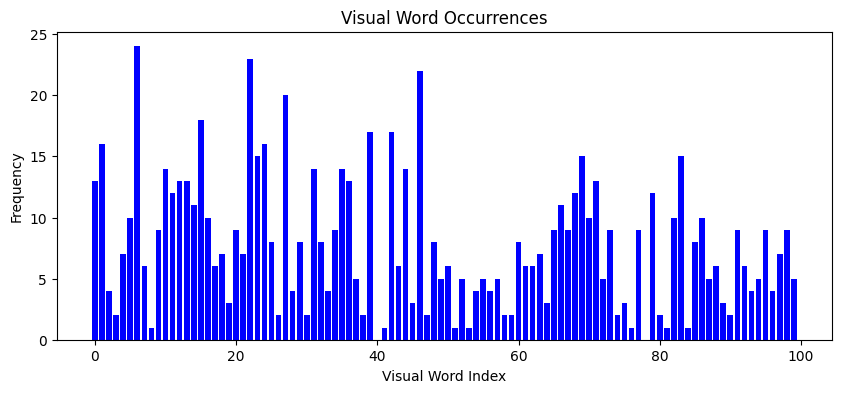

              precision    recall  f1-score   support

          00       0.19      0.41      0.26        66
          01       0.71      0.88      0.78        91
          02       0.31      0.32      0.31       161
          03       0.18      0.32      0.23        60
          04       0.33      0.24      0.28       139
          05       0.51      0.51      0.51       210
          06       0.76      0.87      0.81       178
          07       0.39      0.54      0.45       110
          08       0.44      0.43      0.43       158
          09       0.58      0.59      0.59       224
          10       0.51      0.35      0.42       260
          11       0.46      0.45      0.45       142
          12       0.59      0.42      0.49       206
          13       0.32      0.34      0.33        65
          14       0.62      0.45      0.52       165

    accuracy                           0.48      2235
   macro avg       0.46      0.47      0.46      2235
weighted avg       0.50   

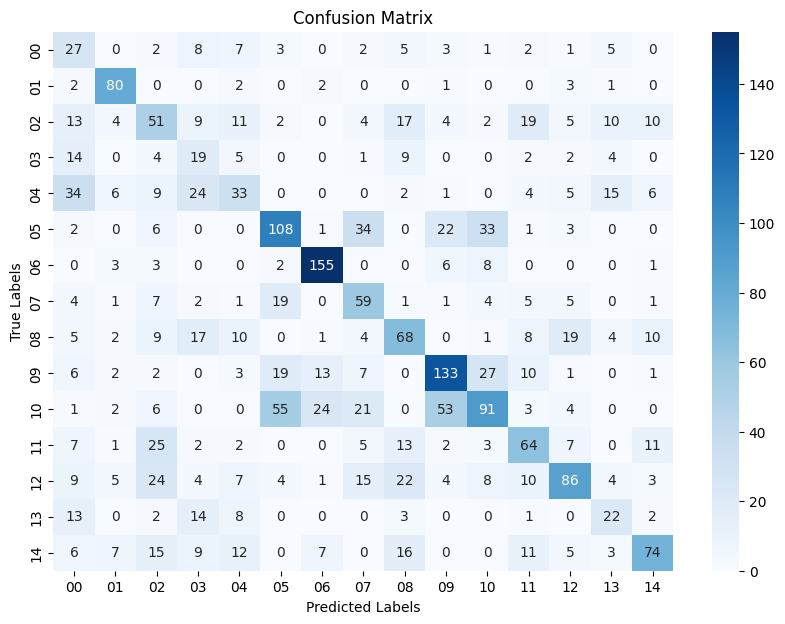

In [4]:
test(100, 'linear')

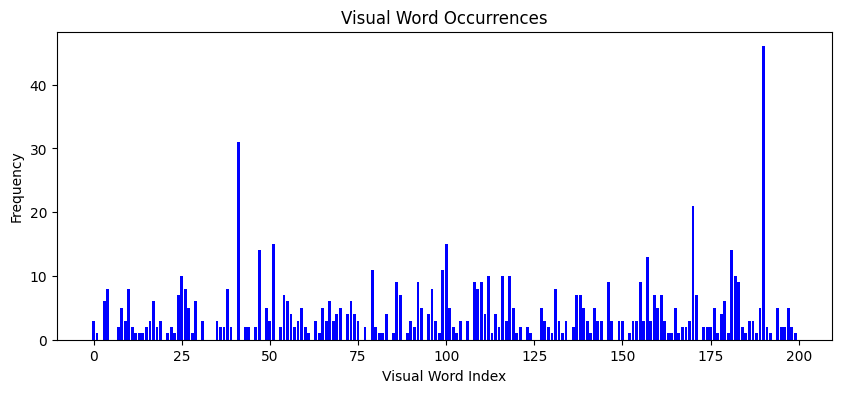

              precision    recall  f1-score   support

          00       0.24      0.52      0.33        66
          01       0.80      0.92      0.86        91
          02       0.25      0.24      0.25       161
          03       0.20      0.38      0.26        60
          04       0.43      0.34      0.38       139
          05       0.58      0.61      0.60       210
          06       0.78      0.85      0.82       178
          07       0.42      0.58      0.49       110
          08       0.50      0.47      0.48       158
          09       0.55      0.57      0.56       224
          10       0.56      0.42      0.48       260
          11       0.47      0.40      0.43       142
          12       0.69      0.48      0.56       206
          13       0.34      0.35      0.35        65
          14       0.59      0.51      0.55       165

    accuracy                           0.51      2235
   macro avg       0.49      0.51      0.49      2235
weighted avg       0.53   

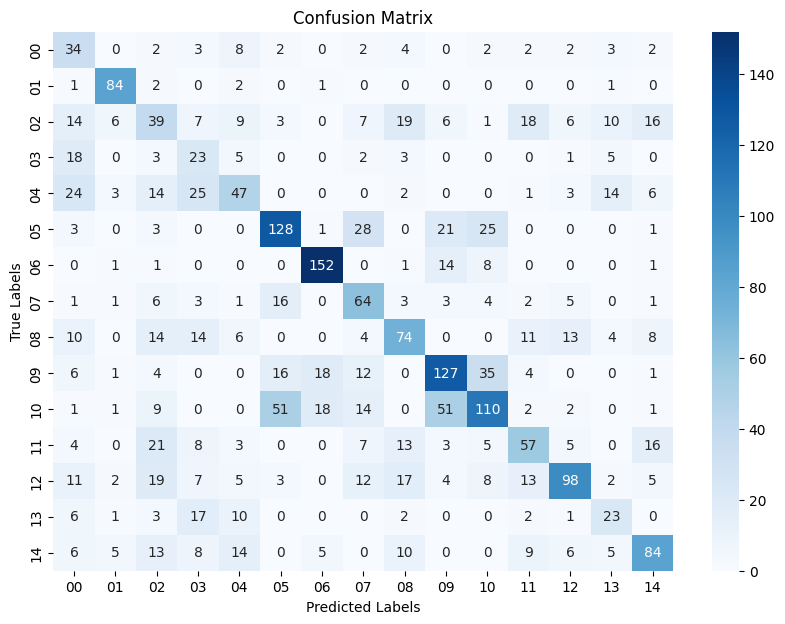

In [5]:
test(200, 'linear')

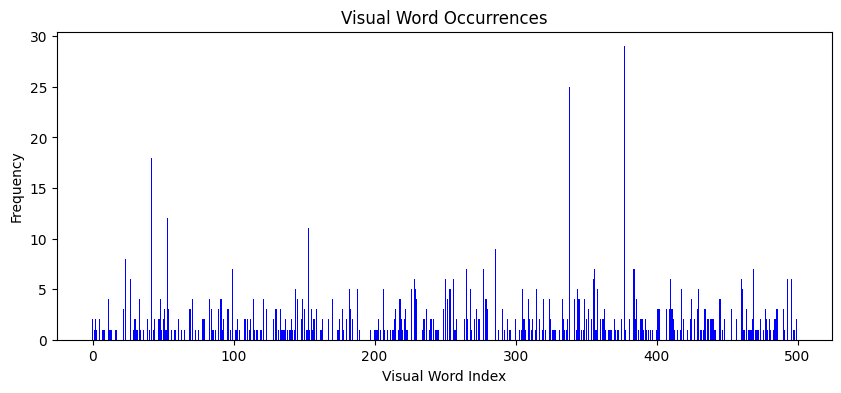

              precision    recall  f1-score   support

          00       0.21      0.52      0.30        66
          01       0.79      0.88      0.83        91
          02       0.36      0.34      0.35       161
          03       0.20      0.35      0.25        60
          04       0.47      0.32      0.38       139
          05       0.58      0.64      0.60       210
          06       0.80      0.90      0.84       178
          07       0.53      0.65      0.58       110
          08       0.50      0.47      0.49       158
          09       0.58      0.58      0.58       224
          10       0.60      0.41      0.49       260
          11       0.54      0.50      0.52       142
          12       0.73      0.51      0.60       206
          13       0.48      0.60      0.53        65
          14       0.62      0.54      0.58       165

    accuracy                           0.54      2235
   macro avg       0.53      0.55      0.53      2235
weighted avg       0.57   

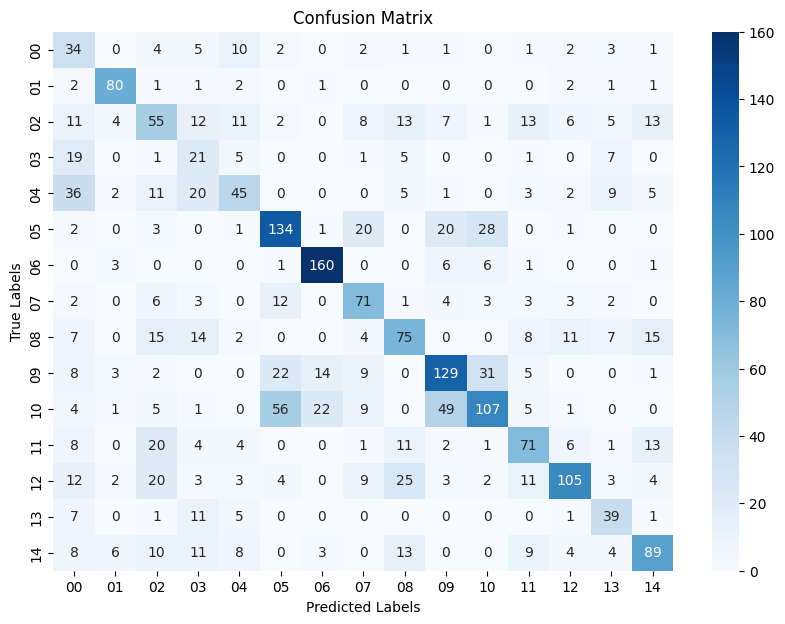

In [6]:
test(500, "linear")

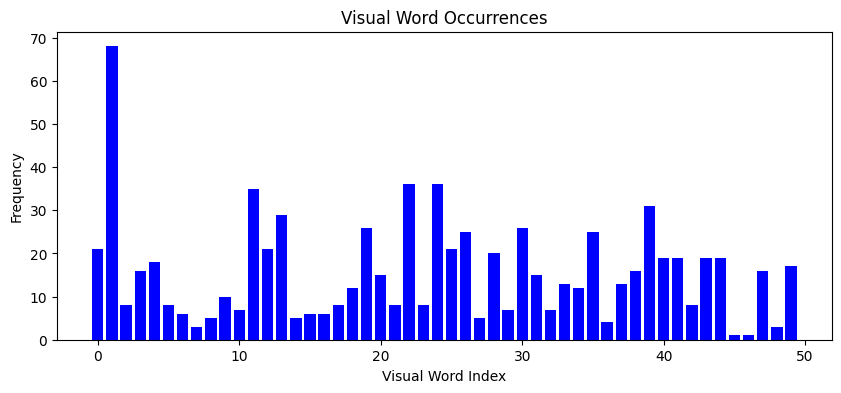

              precision    recall  f1-score   support

          00       0.25      0.35      0.29        66
          01       0.79      0.89      0.84        91
          02       0.42      0.20      0.28       161
          03       0.22      0.30      0.26        60
          04       0.40      0.32      0.35       139
          05       0.64      0.65      0.64       210
          06       0.74      0.88      0.80       178
          07       0.37      0.69      0.48       110
          08       0.55      0.49      0.52       158
          09       0.60      0.55      0.57       224
          10       0.65      0.41      0.50       260
          11       0.48      0.61      0.54       142
          12       0.65      0.51      0.58       206
          13       0.32      0.65      0.43        65
          14       0.59      0.56      0.58       165

    accuracy                           0.54      2235
   macro avg       0.51      0.54      0.51      2235
weighted avg       0.56   

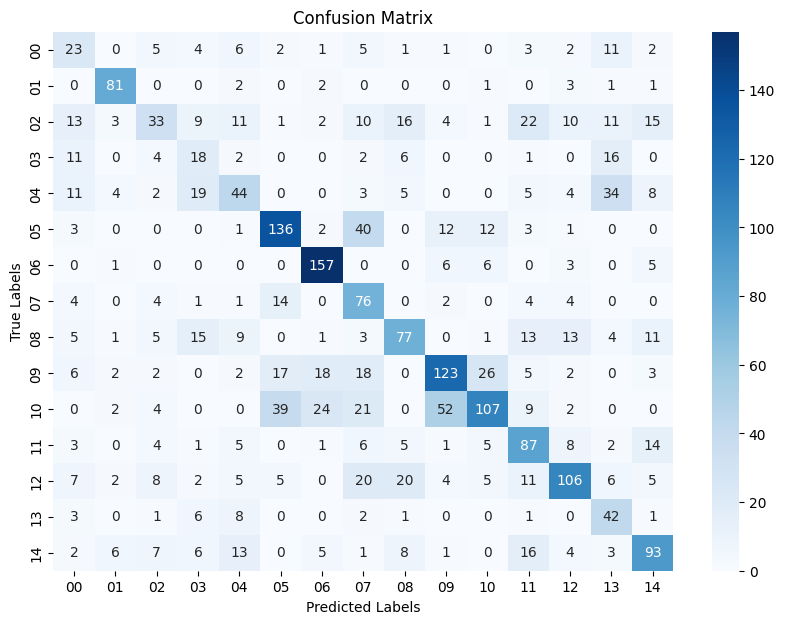

In [7]:
test(50, 'rbf')

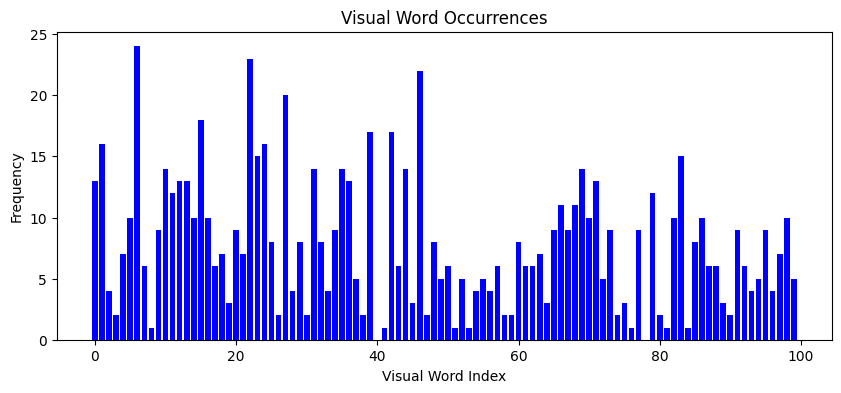

              precision    recall  f1-score   support

          00       0.24      0.36      0.29        66
          01       0.75      0.85      0.80        91
          02       0.40      0.22      0.28       161
          03       0.21      0.28      0.24        60
          04       0.46      0.33      0.38       139
          05       0.61      0.67      0.64       210
          06       0.78      0.89      0.83       178
          07       0.44      0.71      0.54       110
          08       0.50      0.51      0.50       158
          09       0.63      0.61      0.62       224
          10       0.68      0.42      0.52       260
          11       0.49      0.61      0.55       142
          12       0.68      0.54      0.60       206
          13       0.34      0.66      0.45        65
          14       0.64      0.59      0.61       165

    accuracy                           0.55      2235
   macro avg       0.52      0.55      0.52      2235
weighted avg       0.57   

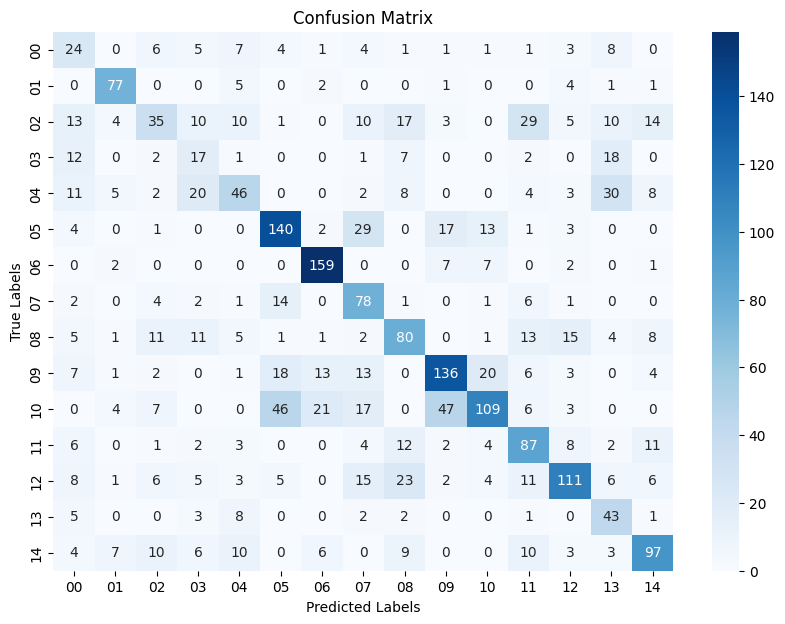

In [8]:
test(100, 'rbf')

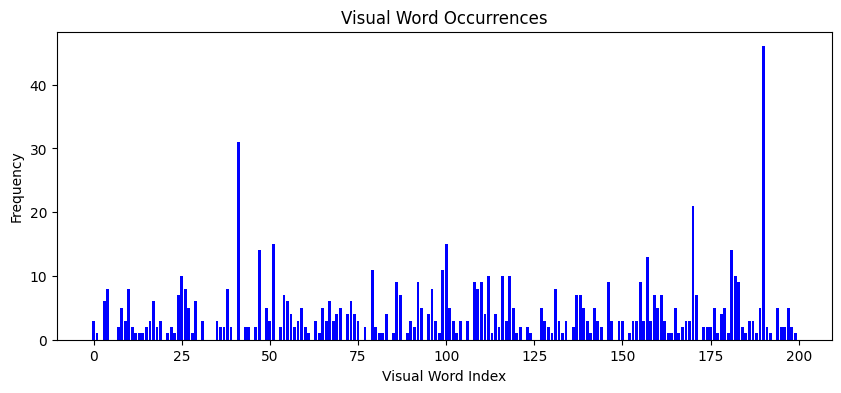

              precision    recall  f1-score   support

          00       0.29      0.45      0.36        66
          01       0.81      0.88      0.84        91
          02       0.36      0.16      0.22       161
          03       0.22      0.35      0.27        60
          04       0.46      0.34      0.39       139
          05       0.63      0.74      0.68       210
          06       0.76      0.89      0.82       178
          07       0.47      0.69      0.56       110
          08       0.54      0.52      0.53       158
          09       0.63      0.63      0.63       224
          10       0.68      0.43      0.53       260
          11       0.49      0.56      0.52       142
          12       0.70      0.57      0.63       206
          13       0.37      0.62      0.46        65
          14       0.62      0.62      0.62       165

    accuracy                           0.57      2235
   macro avg       0.53      0.56      0.54      2235
weighted avg       0.58   

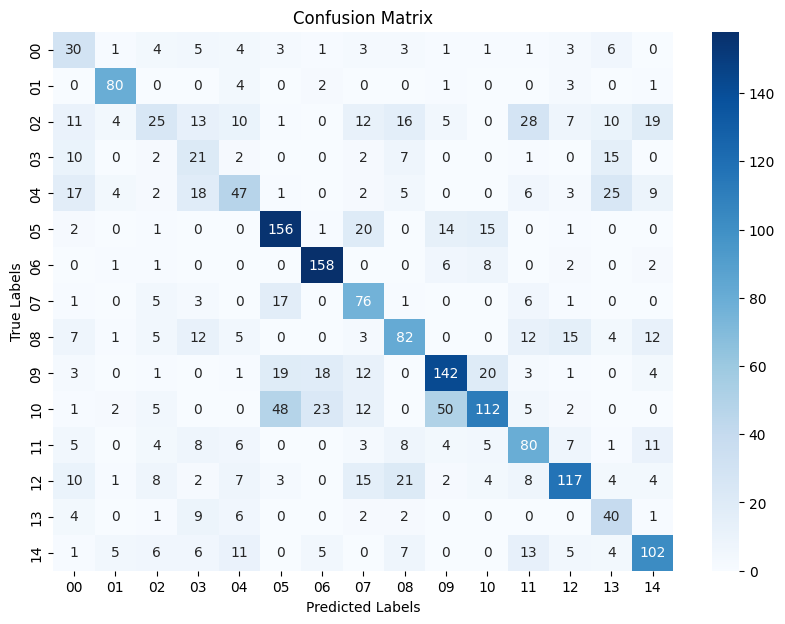

In [9]:
test(200, 'rbf')

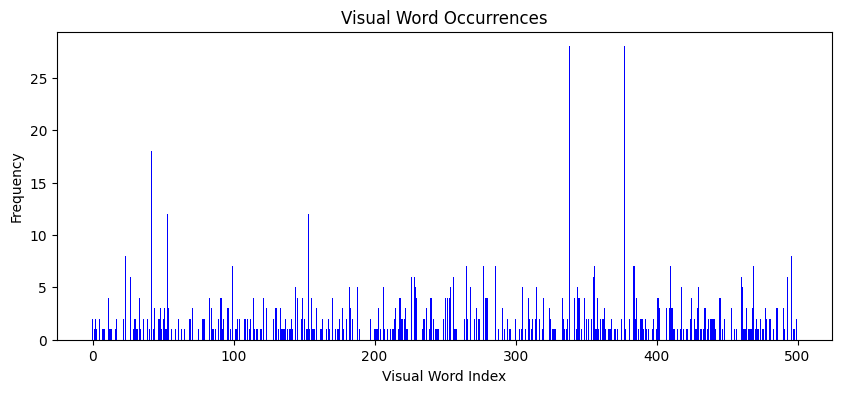

              precision    recall  f1-score   support

          00       0.29      0.44      0.35        66
          01       0.82      0.91      0.86        91
          02       0.44      0.27      0.33       161
          03       0.27      0.37      0.31        60
          04       0.48      0.35      0.40       139
          05       0.59      0.75      0.66       210
          06       0.75      0.86      0.80       178
          07       0.52      0.70      0.60       110
          08       0.59      0.58      0.59       158
          09       0.66      0.64      0.65       224
          10       0.67      0.44      0.53       260
          11       0.57      0.58      0.58       142
          12       0.72      0.57      0.64       206
          13       0.40      0.75      0.52        65
          14       0.63      0.63      0.63       165

    accuracy                           0.59      2235
   macro avg       0.56      0.59      0.56      2235
weighted avg       0.60   

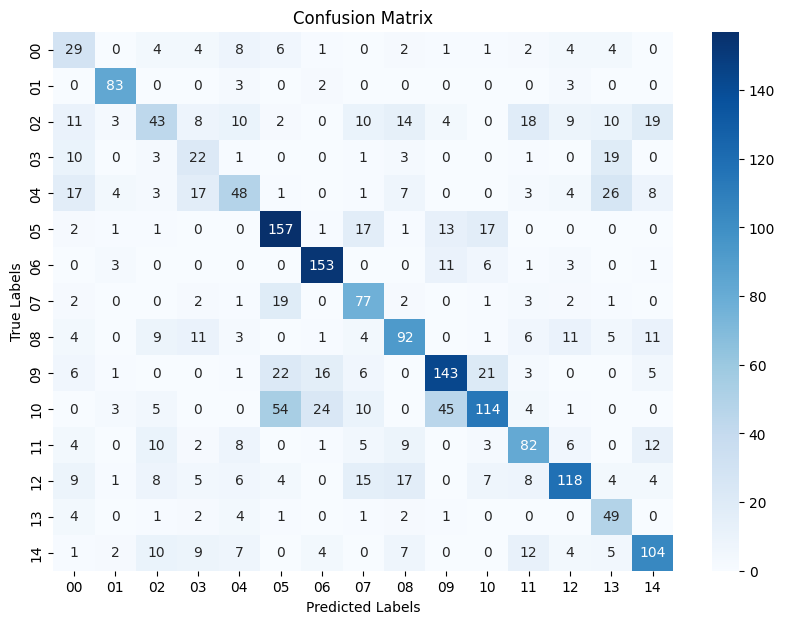

In [10]:
test(500, "rbf")